# Taryn  Michael
# Mfundo Monchwe
# Eli Nimy
# Kyle Groenewald

# NSTD84212 Group Assignment
# Sentiment Analysis using Logistic Regression - FLASK DEPLOYMENT
----

# Background
App Stores are facing a massive problem with user reviews. Evidence suggests that this is 
some discrepancy between user reviews and the actual numeric rating they provide. It is 
therefore essential to find ways to ensure that user reviews match the rating they provide. 

Your team has been approached by Google to develop an API that can be integrated in their 
review page. The goal of the API is to suggest to a user what type of rating to give based on 
the content of their review. When a user types in their review, the API will analyse it and 
suggest whether they should provide a positive or a negative rating. 

The Dataset provided allows you to use past user reviews for training a logistic regression 
classifier that you would deploy with the API. The Dataset contains two columns one is the 
reviews, and the other is titled ratings. The rating column has two values (0 or 1) where zero 
stands for a negative rating and 1 represents a positive rating.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['make', 'want', 'seem', 'run', 'need', 'even', 'not', 'would', 'say', 'could', '_', 
                'be', 'know', 'go', 'get', 'do','get','far','also','way','app','usd','eur','jai','hind','jai_hind',
'done', 'try', 'many','from', 'subject', 're', 'edu','some', 'nice', 'thank','singh','mast','untuk','apne','nise','vgood',
'think', 'see', 'rather', 'lot', 'line', 'even', 'also', 'may', 'use','goog','nce','aap','thik','hai','setu','aarogya_setu','aarogya',
'take', 'come','recommend','recommended','paypal','paytm', 'let','ad','add'])

from nltk.stem import PorterStemmer
from google.colab import files
%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = files.upload()

Saving Dataset.csv to Dataset.csv


In [ ]:
df_reviews = pd.read_csv('Dataset.csv')
df_reviews['Review']=df_reviews['Review'].apply(str)
df_reviews.sample(10)

,Review,Rating
1085,What a refreshing ecperience during this COVID...,1
980,"Loving the app functionality, the timely deliv...",1
2358,This app needs some work to make it work at th...,0
1396,Good customer service and quick delivery,1
2695,"Good service, range of products has improved, ...",1
1456,Nice experience delivery in 3hrs,1
1928,My app won't open. Keeps stopping.,0
764,"Just looking at the reviews, sounds like a goo...",0
2107,Yesterday was my 1st and last nightmare experi...,0
834,Have used the app a few times in the past mont...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


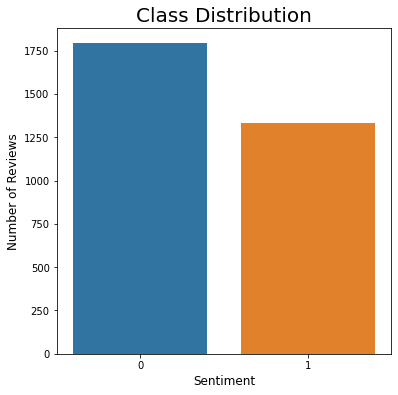

In [ ]:
label_count = df_reviews['Rating'].value_counts()
label_count = label_count.sort_index()

fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("Class Distribution",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12);

### Stopwords removal and stemming

In [ ]:
sw = set(stopwords.words("english"))
ps = PorterStemmer()

In [ ]:
sw = set(stopwords.words("english"))
ps = PorterStemmer()

In [ ]:

def text_prep_stop_stem(text):
    #clean text
    text = re.sub('\S*@\S*\s?', '', text)  # remove emails
    sent = re.sub('\s+', ' ', text)  # remove newline chars
    sent = re.sub("\'", "", text)  # remove single quotes
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('[^a-zA-Z0-9]',' ',text) # remove non english words
    text = re.sub('\s+',' ',text) # remove non english words
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation     
    punct = set(string.punctuation)   
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    return [ps.stem(word) for word in punc_removed.split() if not word in sw]


# Train-Test split

This procedure refers to taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

Here, the test dataset is 30% of the observations.

Since the dataset does not have a balanced number of observations for each class label, the train-test split is stratified. This means that it is split into test and train in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [ ]:
train, test = train_test_split(df_reviews, test_size = 0.3, stratify = df_reviews['Rating'], random_state = 42)

# Transform to bigram and trigram

As we all know, language has a sequential nature, hence the order in which words appear in the text matters a lot. This feature allows us to understand the context of a sentence even if there are some words missing.

This brings us up to the idea behind the N-Grams, where the formal definition is “a contiguous sequence of n items from a given sample of text”. The main idea is that given any text, we can split it into a list of unigrams (1-gram), bigrams (2-gram), trigrams (3-gram) etc.

This simplifies our model so that we do not need to keep track of the whole sentence and review in order to predict the next word or predict the sentiment of the review.

In [ ]:
start_time = time.time()
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(2,3))
cv.fit_transform(train['Review'].values)
train_feature_set=cv.transform(train['Review'].values)
test_feature_set=cv.transform(test['Review'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.01  mins


### Logistic Regression Model

In [ ]:
y_train = train['Rating'].values
y_test = test['Rating'].values

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
#print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       538
           1       0.84      0.82      0.83       400

    accuracy                           0.86       938
   macro avg       0.85      0.85      0.85       938
weighted avg       0.86      0.86      0.86       938



#### Confusion Matrix

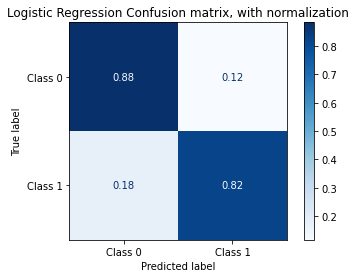

In [ ]:

disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

#### Feature Importance

In [ ]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  10 minutes Score:  -0.3209508138181583
Feature:  20 minutes Score:  0.02845751366352944
Feature:  30 items Score:  -0.379089276231728
Feature:  30 minutes Score:  0.8342414653367362
Feature:  60 60 Score:  -0.3427435008235441
Feature:  60 minutes Score:  0.22144126225760952
Feature:  able to Score:  0.28344624844296357
Feature:  able to order Score:  0.021059767029668202
Feature:  about it Score:  -0.1730621641542829
Feature:  about the Score:  -0.022611021452884836


In [ ]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

#### Top 10 words/phrases for the positive ratings

In [ ]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['excellent service', 'thank you', 'great service', 'love it', 'great app', 'fast and', 'the best', 'quick and', 'easy and', 'love this']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


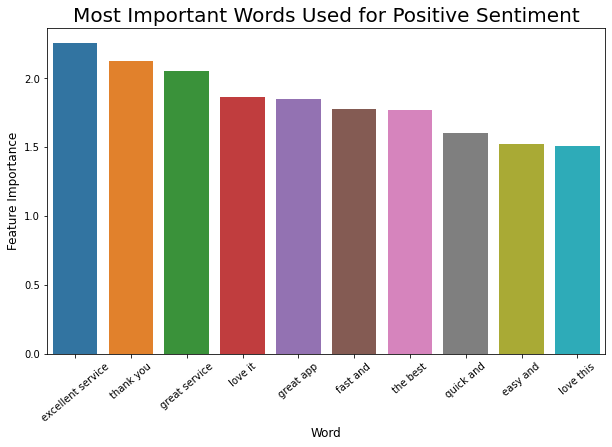

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

#### Top 10 words for negative sentiment

In [ ]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['does not', 'my money', 'doesn work', 'do not', 'not working', 'terrible service', 'keeps crashing', 'not delivered', 'worst app', 'my address']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


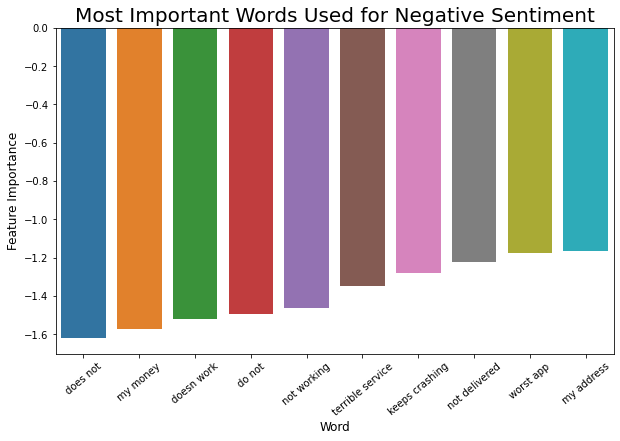

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [ ]:
test_review = cv.transform(["The app provides the best services"])
lr.predict_proba(test_review)

array([[0.18025258, 0.81974742]])

Correctly regards it as a positive rating (82% sure it is a positive rating)

In [ ]:
test_review = cv.transform(["I did not enjoy using the app"])
lr.predict_proba(test_review)

array([[0.6520118, 0.3479882]])

Correctly deems it a negative review (65% sure it is a negative review)